In [17]:
import os
from dotenv import load_dotenv
import pandas as pd
import duckdb
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List, Literal
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import glob
from langfuse.langchain import CallbackHandler
from langsmith import traceable

load_dotenv()

# LangSmith setup
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agent1"

langfuse_handler = CallbackHandler()

print(f"LangSmith Tracing Enabled: {os.getenv('LANGCHAIN_TRACING_V2')}")



LangSmith Tracing Enabled: true


In [18]:
# File discovery
data_folder = r"C:\Users\AkshayRedekar\Documents\POC-Excel-Capabilities\data\imdb"
csv_files = glob.glob(os.path.join(data_folder, '**/*.csv'), recursive=True)
excel_files = glob.glob(os.path.join(data_folder, '**/*.xlsx'), recursive=True)
excel_files += glob.glob(os.path.join(data_folder, '**/*.xls'), recursive=True)
all_files = csv_files + excel_files
print(f"Files found: {len(all_files)}")

if len(all_files) == 0:
    raise FileNotFoundError(f"No CSV or Excel files found in '{data_folder}'")

for file in all_files:
    print(f"  - {os.path.basename(file)}")

def load_file(file_path):
    """Load CSV or Excel file into a pandas DataFrame"""
    try:
        if file_path.endswith('.csv'):
            return pd.read_csv(file_path)
        elif file_path.endswith(('.xlsx', '.xls')):
            return pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return None

print("File loading function defined!")

Files found: 1
  - IMDB-Movie-Data.csv
File loading function defined!


In [19]:
# Database setup with enhanced schema information
db_file_path = "./db/new.duckdb"
os.makedirs(os.path.dirname(db_file_path), exist_ok=True)

duckdb_connection = duckdb.connect(db_file_path)

table_info = {}
all_file_info = []

for file_path in all_files:
    dataframe = load_file(file_path)
    if dataframe is not None:
        table_name = os.path.splitext(os.path.basename(file_path))[0].replace(' ', '_').replace('-', '_')
        
        duckdb_connection.register('temp_df', dataframe)
        duckdb_connection.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM temp_df")
        duckdb_connection.unregister('temp_df')
        
        # Get column data types and sample values
        column_info = []
        for col in dataframe.columns:
            dtype = str(dataframe[col].dtype)
            sample_vals = dataframe[col].dropna().head(3).tolist()
            column_info.append({
                'name': col,
                'type': dtype,
                'samples': sample_vals
            })
        
        table_info[table_name] = column_info
        all_file_info.append({
            'table_name': table_name,
            'columns': dataframe.columns.tolist(),
            'column_details': column_info,
            'total_rows': len(dataframe),
            'file_path': file_path
        })


# Enhanced SQL schema with detailed information
def create_enhanced_schema():
    schema = "=== DATABASE SCHEMA ===\n\n"
    
    for info in all_file_info:
        schema += f"TABLE: {info['table_name']}\n"
        schema += f"Total Rows: {info['total_rows']}\n"
        schema += "Columns:\n"
        
        for col_detail in info['column_details']:
            col_name = col_detail['name']
            col_type = col_detail['type']
            samples = col_detail['samples'][:2]  # First 2 samples
            
            # Proper column name handling for SQL
            if ' ' in col_name or '(' in col_name:
                sql_col_name = f'"{col_name}"'
            else:
                sql_col_name = col_name
            
            schema += f"  - {sql_col_name} ({col_type})"
            if samples:
                schema += f" | Examples: {samples}"
            schema += "\n"
        
        schema += "\n"
    
    schema += "IMPORTANT SQL RULES:\n"
    schema += "1. Always quote column names containing spaces or special characters using double quotes.\n"
    schema += '   Example: SELECT "Column Name With Spaces" FROM table_name;\n'
    schema += "2. For text search across any text-based column, use the LIKE operator with % wildcards.\n"
    schema += "   Example: WHERE column_name LIKE '%keyword%';\n"
    schema += "3. When filtering by categorical or tag-based columns (e.g., genre, category, label), use partial matches.\n"
    schema += "   Example: WHERE category_column LIKE '%value%';\n"
    schema += "4. For numerical comparisons, use standard operators (>, <, >=, <=, =).\n"
    schema += "   Example: WHERE rating >= 8.0;\n"
    schema += "5. When joining multiple tables, use clear JOIN conditions on matching keys.\n"
    schema += "   Example: SELECT * FROM table1 JOIN table2 ON table1.id = table2.id;\n"
    schema += "6. Always end SQL statements with a semicolon when executing directly.\n"
    schema += "7. Use LIMIT to control result size for large datasets.\n"
    schema += "   Example: SELECT * FROM table_name LIMIT 10;\n\n"

    
    return schema

sql_schema = create_enhanced_schema()


In [20]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]
    sql_context: str
    answer: str
    retry_count: int
    error_message: str

print("Agent state defined!")

@traceable
def generate_sql(state: AgentState):
    """Node to generate SQL query from question with enhanced context"""
    print("[GENERATE SQL]")
    
    question = state["messages"][0].content
    retry_count = state.get("retry_count", 0)
    error_msg = state.get("error_message", "")
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    # Enhanced prompt with better instructions
    prompt = f"""{sql_schema}

QUESTION: {question}

INSTRUCTIONS:
1. Generate a VALID DuckDB SQL query to answer the question
2. Use double quotes for column names with spaces: "Column Name"
3. For narrative/story questions, search in the Description field using LIKE
4. For genre questions, use LIKE since Genre contains comma-separated values
5. Return ONLY the SQL query, no explanations or markdown
6. Do not use code blocks or formatting

"""
    
    if retry_count > 0 and error_msg:
        prompt += f"""
PREVIOUS ERROR: {error_msg}

Fix the SQL query based on the error above. Common fixes:
- Use double quotes for columns with spaces: "Revenue (Millions)"
- Use LIKE '%keyword%' for text search in Description
- Check column names match the schema exactly
"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    sql_query = response.content.strip()
    
    # Clean up SQL query
    sql_query = sql_query.replace("```sql", "").replace("```", "").strip()
    lines = sql_query.split('\n')
    clean_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith('--') and not line.startswith('#'):
            clean_lines.append(line)
    sql_query = ' '.join(clean_lines)
    sql_query = sql_query.split(';')[0].strip()
    
    print(f"Generated SQL: {sql_query}")
    return {"sql_context": f"Generated SQL: {sql_query}", "retry_count": retry_count}

print("Generate SQL node defined!")

Agent state defined!
Generate SQL node defined!


In [21]:
@traceable(run_type="tool", name="execute_sql_node")
def execute_sql(state: AgentState):
    """Node to execute SQL query with error handling"""
    print("[EXECUTE SQL]")
    
    sql_context = state.get("sql_context", "")
    sql_query = sql_context.replace("Generated SQL: ", "").strip()
    
    try:
        result = duckdb_connection.execute(sql_query).fetchall()
        columns = [desc[0] for desc in duckdb_connection.description]
        
        result_text = f"SQL Query: {sql_query}\n\nResults ({len(result)} rows):\n"
        result_text += f"Columns: {', '.join(columns)}\n\n"
        
        # Show more results for better context
        for row in result[:50]:
            result_text += str(row) + "\n"
        
        if len(result) > 50:
            result_text += f"\n... ({len(result) - 50} more rows)"
        
        return {"sql_context": result_text, "error_message": ""}
    
    except Exception as e:
        error_msg = f"SQL Error: {str(e)}\nQuery: {sql_query}"
        print(error_msg)
        return {"sql_context": error_msg, "error_message": str(e)}

def should_retry(state: AgentState) -> Literal["generate_sql", "generate_answer"]:
    """Decide whether to retry SQL generation or proceed to answer"""
    retry_count = state.get("retry_count", 0)
    error_msg = state.get("error_message", "")
    
    # If there's an error and we haven't retried too many times
    if error_msg and "SQL Error" in state.get("sql_context", "") and retry_count < 2:
        print(f"[RETRY] Attempt {retry_count + 1}")
        return "generate_sql"
    
    return "generate_answer"

print("Execute SQL node with retry logic defined!")

Execute SQL node with retry logic defined!


In [22]:
@traceable
def generate_answer(state: AgentState):
    """Node to generate final answer from SQL results"""
    print("[GENERATE ANSWER]")
    
    sql_context = state.get("sql_context", "")
    question = state["messages"][0].content
    error_msg = state.get("error_message", "")
    
    system_msg = f"""You are a helpful assistant answering questions about movie data.
    
Database Schema:
{sql_schema}

Guidelines:
1. If the SQL query returns 0 rows, explain that no records in the database match the given criteria.
2. For descriptive or narrative-style questions, clarify that the database may not contain such detailed textual information.
3. Present query results clearly and concisely, focusing on the most relevant data.
4. If an SQL error occurs, describe in simple terms what might have gone wrong (e.g., invalid column name, syntax issue, or missing data).
5. Always be factual, accurate, and helpful based on the available dataset and query results.
"""

    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    response = llm.invoke(
        [
            SystemMessage(content=system_msg),
            HumanMessage(content=f"SQL Results: {sql_context}\n\nQuestion: {question}")
        ],
        config={"callbacks": [langfuse_handler]}
    )
    
    final_msg = AIMessage(content=response.content)
    return {"messages": [final_msg], "answer": response.content}

print("Generate answer node defined!")

Generate answer node defined!


✅ SQL Agent!


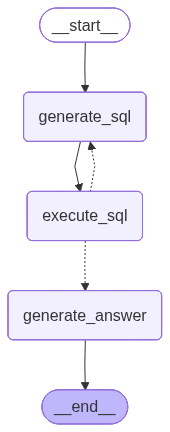

In [23]:
# Build the enhanced workflow with retry logic
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("generate_sql", generate_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_answer", generate_answer)

# Add edges with conditional retry
workflow.add_edge(START, "generate_sql")
workflow.add_edge("generate_sql", "execute_sql")
workflow.add_conditional_edges(
    "execute_sql",
    should_retry,
    {
        "generate_sql": "generate_sql",
        "generate_answer": "generate_answer"
    }
)
workflow.add_edge("generate_answer", END)

# Compile the graph
graph = workflow.compile()

print("✅ SQL Agent!")

# Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available in this environment")

In [24]:
@traceable
def run_query_pipeline(question: str):
    """Main pipeline to run a query through the agent"""
    result = graph.invoke(
        {
            "messages": [HumanMessage(content=question)],
            "retry_count": 0,
            "error_message": ""
        },
        config={"callbacks": [langfuse_handler]}
    )
    return result['messages'][-1].content

# Test questions
questions = [
    "Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?",
    "Which movie explores a father's fight against a supernatural illness threatening his child in a rural village?",
    "Which uplifting Bollywood movie follows a curious outsider asking innocent questions?",
    "Which movie shows how teamwork inside a military command leads to ethical decisions protecting innocent life?",
    "Which movie explores how a blind man regains sight but loses clarity in life due to superficial obsession?",
    "Which movie has the highest IMDb rating in the dataset?",
    "Find the top 3 highest-revenue movies released after 2010, sorted descending.",
    "How many movies have Runtime > 150 minutes AND rating ≥ 8.0?",
    "Which 3 directors have directed the most movies in the dataset?",
    "Count all movies belonging to the Sci-Fi genre (even if mixed)."
]

# Run all questions
import time


for i, question in enumerate(questions, start=1):
    print(f"QUERY {i}/{len(questions)}")
    print(f"Q: {question}\n")
    try:
        answer = run_query_pipeline(question)
        print(f"A: {answer}")
    except Exception as e:
        print(f"ERROR: {str(e)}")
    
    if i < len(questions):
        print("\nWaiting 15 seconds before next query...")
        time.sleep(15)

print("\n" + "="*80)
print("ALL QUERIES COMPLETED")
print("="*80)

QUERY 1/10
Q: Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?

[GENERATE SQL]
Generated SQL: SELECT * FROM IMDB_Movie_Data WHERE "Description" LIKE '%young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death%'
[EXECUTE SQL]
[GENERATE ANSWER]
A: It appears that there are no records in the database that match the description of a movie involving a young girl experiencing an out-of-body dilemma after a tragic accident. Therefore, I cannot provide the title or details of such a movie based on the available data. If you have any other queries or need information on different movies, feel free to ask!

Waiting 15 seconds before next query...
QUERY 2/10
Q: Which movie explores a father's fight against a supernatural illness threatening his child in a rural village?

[GENERATE SQL]
Generated SQL: SELECT * FROM IMDB_Movie_Data WHERE "Description" 

In [25]:
# import time

# for i, question in enumerate(questions, start=1):
    
#     print(f"[QUERY {i}] {question}")
#     answer = run_query_pipeline(question)

#     print(f"[ANSWER]\n{answer}\n")

#     if i < len(questions):
#         time.sleep(15)
